In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
# Display setting to better visualize notebook
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',10)
pd.set_option('display.width',1000)

In [3]:
# Read Aggregated  data
df = pd.read_csv('New_features.csv')

In [4]:
df.shape

(5410, 13)

In [5]:
df.columns

Index(['Provider', 'IP_average_claim_duration', 'OP_average_claim_duration', 'PotentialFraud', 'IP_Claims_Total', 'OP_Claims_Total', 'IP_Averagedaysinhospital', 'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt', 'IP_total_diagnosis', 'OP_total_diagnosis', 'IP_total_procedures', 'OP_total_procedures'], dtype='object')

In [6]:
df.head()

,Provider,IP_average_claim_duration,OP_average_claim_duration,PotentialFraud,IP_Claims_Total,OP_Claims_Total,IP_Averagedaysinhospital,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt,IP_total_diagnosis,OP_total_diagnosis,IP_total_procedures,OP_total_procedures
0,PRV51001,5.0,1.0,No,97000.0,7640.0,5.0,890.0,475.0,36.0,44.0,3.0,0.0
1,PRV51003,5.0,2.0,Yes,573000.0,32670.0,5.0,823.0,665.0,503.0,190.0,48.0,0.0
2,PRV51004,0.0,1.0,No,0.0,52170.0,0.0,454.0,601.0,0.0,385.0,0.0,0.0
3,PRV51005,0.0,1.0,Yes,0.0,280910.0,0.0,399.0,476.0,0.0,3016.0,0.0,0.0
4,PRV51007,5.0,1.0,No,19000.0,14710.0,5.0,424.0,431.0,22.0,193.0,1.0,0.0


In [7]:
X=df.drop(columns=['Provider','PotentialFraud'])

In [8]:
X.shape

(5410, 11)

In [9]:
y=df['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

In [10]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [42]:
# comparison with and without tuning

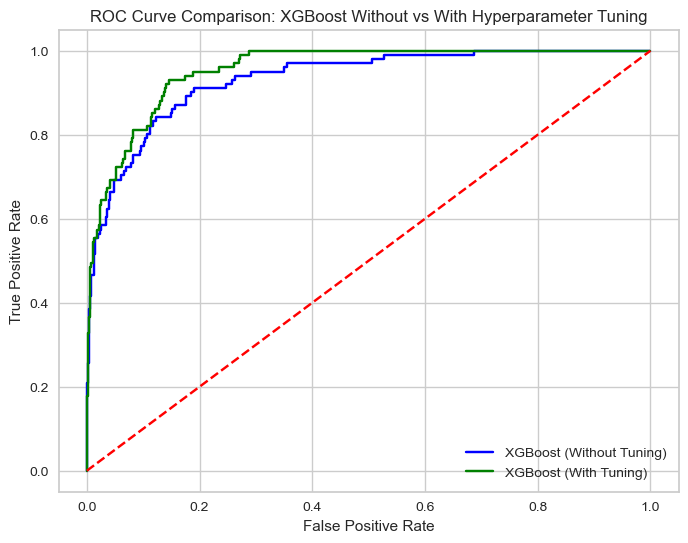

XGBoost Without Hyperparameter Tuning:
Accuracy: 0.9344
Precision: 0.6705
Recall: 0.5842
F1-score: 0.6243
ROC-AUC: 0.9324

XGBoost With Hyperparameter Tuning:
Accuracy: 0.9473
Precision: 0.8333
Recall: 0.5446
F1-score: 0.6587
ROC-AUC: 0.9544


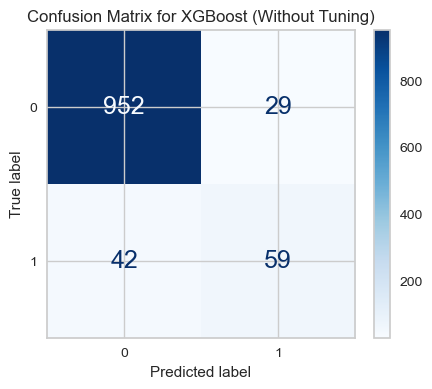

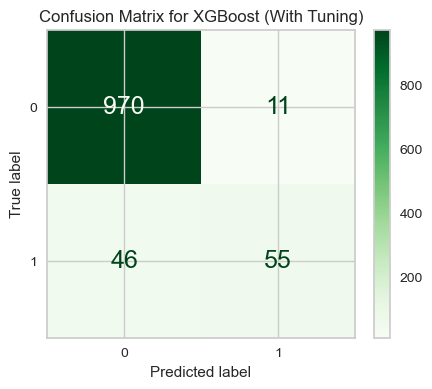

In [120]:
# XG Boost
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------ XGBoost without Hyperparameter Tuning ------
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(random_state=42))])

model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# ------ XGBoost with Hyperparameter Tuning ------
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make Predictions with the Best Model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Compute ROC Curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='XGBoost (Without Tuning)')
plt.plot(fpr_best, tpr_best, color='green', label='XGBoost (With Tuning)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: XGBoost Without vs With Hyperparameter Tuning')
plt.legend(loc='lower right')
plt.show()

# Print performance metrics
print(f'XGBoost Without Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}')

print(f'\nXGBoost With Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_best, pos_label=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_best, pos_label=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred_best):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}')

# Compute confusion matrices
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Function to plot confusion matrix with larger text labels
def plot_conf_matrix(conf_matrix, title, cmap):
    fig, ax = plt.subplots(figsize=(5, 4))  # Reduced figure size for compact display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=cmap, ax=ax, values_format='d')  # Ensure integer format
    ax.set_title(title, fontsize=12)

    # Increase font size of numbers inside the matrix
    for text in ax.texts:
        text.set_fontsize(18)

    plt.show()

# Plot confusion matrices
plot_conf_matrix(conf_matrix, 'Confusion Matrix for XGBoost (Without Tuning)', 'Blues')
plot_conf_matrix(conf_matrix_best, 'Confusion Matrix for XGBoost (With Tuning)', 'Greens')
